### Resource : https://substack.com/@pedma7/p-161281501

### Importing Dependencies

In [1]:
import pandas as pd
import vectorbt as vbt
from tqdm import tqdm
import matplotlib.pyplot as plt
import empyrical as ep
import requests
import numpy as np

/Users/vkotopoulos/Dev/vkotopoulos/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning:

urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020



### Loading Data

In [2]:
def get_binance_futures_pairs(quote='USDT'):
    url = 'https://fapi.binance.com/fapi/v1/exchangeInfo'
    response = requests.get(url)
    data = response.json()

    usdc_pairs = []
    for symbol_info in data['symbols']:
        if symbol_info['quoteAsset'] == quote and symbol_info['status'] == 'TRADING':
            usdc_pairs.append(symbol_info['symbol'])

    return usdc_pairs

pairs = get_binance_futures_pairs(quote='USDT')
len(pairs)

512

In [68]:
universe = pairs[:50]

In [ ]:
data = {'Open': {}, 'High': {}, 'Low': {}, 'Close': {}, 'Volume': {}}
for pair in tqdm(universe):
    try:
        df = vbt.BinanceData.download([pair], start='2015-01-01', show_progress=False)
        data['Open'][pair] = df.get('Open')
        data['High'][pair] = df.get('High') 
        data['Low'][pair] = df.get('Low')
        data['Close'][pair] = df.get('Close')
        data['Volume'][pair] = df.get('Volume')
    except:
        pass

open = pd.DataFrame(data['Open'])
high = pd.DataFrame(data['High'])
low = pd.DataFrame(data['Low']) 
close = pd.DataFrame(data['Close'])
volume = pd.DataFrame(data['Volume'])

  6%|▌         | 3/50 [00:19<04:55,  6.29s/it]

In [26]:
open.to_csv('binance_usdt_futures_open.csv')
high.to_csv('binance_usdt_futures_high.csv')
low.to_csv('binance_usdt_futures_low.csv')
close.to_csv('binance_usdt_futures_close.csv')
volume.to_csv('binance_usdt_futures_volume.csv')

### Implementing the Base Strategy on BTC

In [5]:
open = pd.read_csv('binance_usdt_futures_open.csv')
high = pd.read_csv('binance_usdt_futures_high.csv')
low = pd.read_csv('binance_usdt_futures_low.csv')
close = pd.read_csv('binance_usdt_futures_close.csv')
volume = pd.read_csv('binance_usdt_futures_volume.csv')

open['Open time'] = pd.to_datetime(open['Open time'])
open.set_index('Open time', inplace=True)

high['Open time'] = pd.to_datetime(high['Open time'])
high.set_index('Open time', inplace=True)

low['Open time'] = pd.to_datetime(low['Open time'])
low.set_index('Open time', inplace=True)

close['Open time'] = pd.to_datetime(close['Open time'])
close.set_index('Open time', inplace=True)

volume['Open time'] = pd.to_datetime(volume['Open time'])
volume.set_index('Open time', inplace=True)

### Running the Strategy in whole universe

In [145]:
rsi = vbt.RSI.run(close[universe], window=14).rsi
rsi.columns = universe

entries = rsi.vbt.crossed_above(50)
short_entries = rsi.vbt.crossed_below(50)

pf = vbt.Portfolio.from_signals(close[universe], 
                                entries=entries, 
                                exits=short_entries, 
                                fees=0.00)

In [71]:
# close['ADAUSDT'].plot()
# pf.value().plot(logy=False)

In [146]:
exposure = pf.assets()

In [147]:
def vol_targeted_weights(
    exposures: pd.DataFrame,
    returns: pd.DataFrame,
    target_vol: float = 0.80,       # 80% annualized
    ann_factor: int = 365,          # crypto: 365; traditional markets: 252
    lookback: int = 30,             # rolling window for std if not using EWMA
    use_ewma: bool = False,         # set True to use EWMA vol
    ewm_span: int = 30,             # EWMA span (approx lookback)
    cap_leverage: float = None,  # e.g., 3.0 to cap absolute gross leverage; None for no cap
    time_col: str = "Open time"  # if your exposures has a datetime column to keep
) -> pd.DataFrame:
    """
    Returns a weights DataFrame with same shape/columns as exposures (and same index).
    The portfolio's realized (rolling) annualized vol is targeted to `target_vol`.
    """
    # --- Prep & align ---
    exp = exposures.copy()
    # If time column exists, move it to index (but keep a copy to add back later)
    keep_time = None
    if time_col and time_col in exp.columns:
        keep_time = exp[time_col].copy()
        exp = exp.drop(columns=[time_col])
        # ensure datetime index (optional but recommended)
        try:
            idx = pd.to_datetime(keep_time, utc=True, errors="coerce")
            exp.index = idx
        except Exception:
            pass

    # Ensure numeric
    exp = exp.apply(pd.to_numeric, errors="coerce")

    # Align with returns (intersect columns & index)
    ret = returns.copy()
    ret = ret.apply(pd.to_numeric, errors="coerce")
    common_cols = exp.columns.intersection(ret.columns)
    exp = exp[common_cols]
    ret = ret[common_cols]
    # Align on time index
    exp, ret = exp.align(ret, join="inner", axis=0)

    # --- Build baseline daily weights from raw signals (equal notional per active asset) ---
    # equal-notional weights each day: signal / sum(|signal|)
    gross = exp.abs().sum(axis=1).replace(0.0, np.nan)
    base_w = exp.div(gross, axis=0).fillna(0.0)

    # --- Compute baseline portfolio returns using LAGGED weights (no look-ahead) ---
    base_w_lag = base_w.shift(1).fillna(0.0)
    port_ret = (base_w_lag * ret).sum(axis=1)

    # --- Realized vol estimate (daily) & annualize ---
    if use_ewma:
        # EWMA std of returns (daily)
        # pandas EWM std is already std, so annualize after
        daily_vol = port_ret.ewm(span=ewm_span, min_periods=ewm_span).std()
    else:
        daily_vol = port_ret.rolling(lookback, min_periods=lookback).std()

    ann_vol = daily_vol * np.sqrt(ann_factor)

    # --- Compute daily portfolio-level scale factor (target_vol / realized_vol) ---
    scale = (target_vol / ann_vol).replace([np.inf, -np.inf], np.nan).clip(upper=1e6)
    scale = scale.shift(1)  # lag the scale as well to avoid look-ahead
    scale = scale.fillna(0.0)  # until we have enough history, scale = 0 (flat)

    # --- Final weights: scaled baseline weights ---
    weights = base_w.mul(scale, axis=0)

    # Optional: cap gross leverage (sum of abs weights) if desired
    if cap_leverage is not None:
        gross_leverage = weights.abs().sum(axis=1)
        cap_factor = cap_leverage / gross_leverage.replace(0, np.nan)
        cap_factor = cap_factor.clip(upper=1.0).fillna(1.0)
        weights = weights.mul(cap_factor, axis=0)

    # Reattach time column if present
    if keep_time is not None:
        weights = weights.copy()
        weights.insert(0, time_col, keep_time.loc[weights.index])

    return weights


In [148]:
# exposures_df: your raw signals (like the CSV you showed)
# returns_df: your asset returns with same tickers/columns
# Both indexed by datetime (or exposures has "Open time" column)

weights = vol_targeted_weights(
    exposures=exposure,
    returns=close[universe].pct_change().fillna(0),
    target_vol=0.4,     # 80% annualized
    ann_factor=365,      # use 252 for equities
    lookback=7,         # or 60
    use_ewma=False,      # set True to use EWMA
    ewm_span=30,         # relevant only if use_ewma=True
    cap_leverage=1,      # e.g., 3.0 if you want a leverage cap
    time_col="Open time" # omit or change if different
)


/var/folders/62/vhyyy_pj6mb9045zds49k55c0000gn/T/ipykernel_12209/539761561.py:7: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



<Axes: xlabel='Open time'>

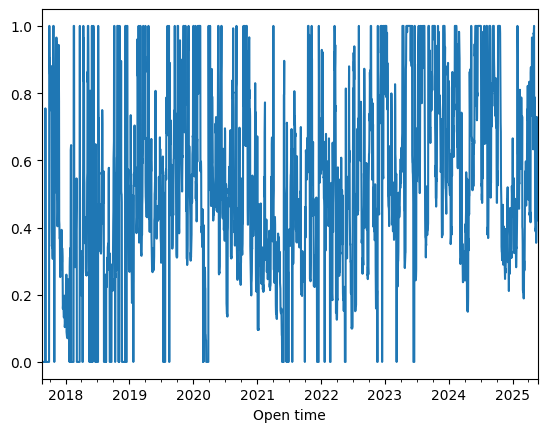

In [149]:
weights.sum(axis=1).plot()

In [150]:
# Run the simulation
pf_target_vol = vbt.Portfolio.from_orders(
    close=close[universe],
    size=weights,
    size_type='targetpercent',
    cash_sharing=True,
    group_by=True,
    call_seq="auto",
    fees=0.001,
    slippage=0.00,
    direction='both'
)

<Axes: xlabel='Open time'>

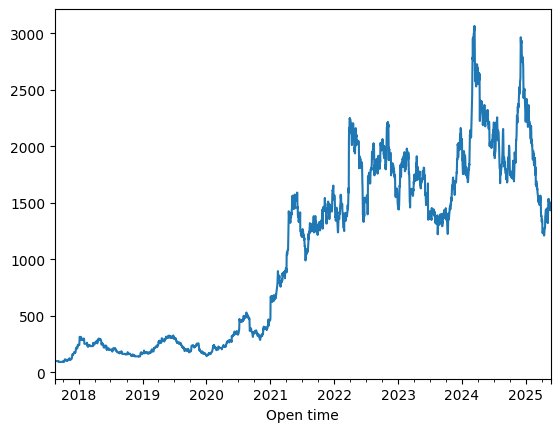

In [151]:
pf_target_vol.value().plot(logy=False)